In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.8)


In [71]:
import os 
os.environ['KAGGLE_USERNAME'] = 'penguin1109'
os.environ['KAGGLE_KEY'] = "72a4225c220b38d4047cba56a019d031"
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


- 외부에서 다운 받는 파일은 colab에서는 '/content' 폴더에 저장이 된다.
- kaggle에서 얻은 API에 저장된 KAGGEL_USERNAME과 KAGGLE_KEY를 이용해서 현재 os에 연동을 하고 원하는 데이터를 다운받으면 된다.
- 각 dataset마다 API가 존재하기 때문에 **이제 사용 방법을 알았으니 Kaggle의 데이터 셋에는 너무나 쉽게 접근**을 할 수 있을 것 같다.
  - stanford-dog-dataset.zip이 저장이 되었고 이를 이제 unzip 해야 한다.

In [ ]:
!unzip stanford-dogs-dataset.zip

- 어떤 사진들로 구성이 되어 있는지 확인해 보자

In [2]:
import pathlib
dog_dir = '/content/images/Images'
dog_dir = pathlib.Path(dog_dir)
dog_directory = list(dog_dir.glob('*/*'))

- 이미지들이 품종 별로 구분이 되어 있기는 하지만 각각의 품종별로 label을 설정해 주기 위해서, 그리고 이를 숫자로 설정해 주어야 하기 때문에(컴퓨터는 수치형 데이터만 받아들일 수 있다.) label_dir과 이미지 저장 경로인 dog_directory를 따로 구분해서 저장했다.

In [3]:
label_dir = list(dog_dir.glob('*/'))
len(label_dir)

120

In [4]:
label_dir[0]

PosixPath('/content/images/Images/n02111500-Great_Pyrenees')

In [5]:
'/'.join(str(dog_directory[0]).split('/')[:-1])

'/content/images/Images/n02111500-Great_Pyrenees'

In [6]:
dog_directory = []
for i in label_dir:
  file = list(i.glob('*'))[:9]
  for j in file:
    dog_directory.append(j)

In [7]:
len(dog_directory)

1080

In [9]:
np.random.randint(0, 100, 9)

array([15,  5, 38, 32, 92, 57, 21,  6, 65])

In [6]:
import matplotlib.pyplot as plt
import cv2
def load_multiple_image_label(image):
  plt.figure(figsize = (16,16))
  index = np.random.randint(0, len(image), 9)
  id = 1
  for i in index:
    plt.subplot(3,3,id)
    id += 1
    plt.imshow(plt.imread(image[i]))
    plt.title(str(image[i]).split('/')[-2])
  plt.show()


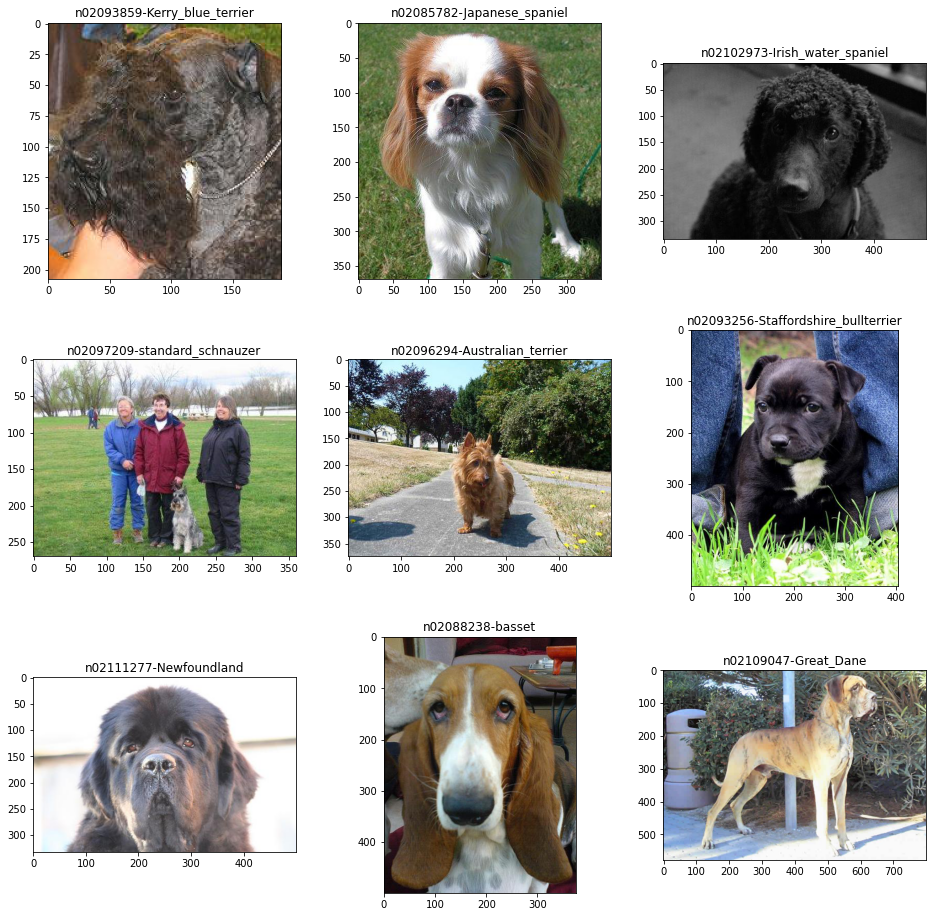

In [7]:
load_multiple_image_label(dog_directory)

#### 전이 학습에 사용할 모델 불러오기
- tf.keras에서 MobileNet V2를 이용할 예정이다.
1. 메모리에 불러온 네트워크의 가중치 초기화
2. 각 layer의 훈련 가능 여부를 True로 바꾼다.
  - 마지막 layer인 Dense layer은 사용하지 않을 것이기 때문에 mobilev2.layers[:-1]를 사용한다.
3. 뉴런에는 각각 가중치 w(kernel)와 편향 b(bias)가 존재하는데, 이째에 bias는 존재하지 않기 떄문에 kernel이 있는지 검사를 해서 있을 경우 그 값을 모두 random으로 초기화 한다.  

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

for layer in mobilev2.layers[:-1]:
  layer.trainable = True

for layer in mobilev2.layers[:-1]:
  if 'kernel' in layer.__dict__:
    kernel_shape = np.array(layer.get_weights()).shape
    #가중치를 평균이 0, 표준편차가 1인 random 변수로 초기화한다.
    layer.set_weights(tf.random.normal(kernel_shape,0,1))

In [9]:
mobilev2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

- model을 summary한 결과에서 알 수 있듯이 input받는 image데이터의 shape는 (None,224,224,3)이어야 하고 따라서 stanford dog의 이미지를 이렇게 맞춰 주어야 한다.

- 단 여기서 google colab을 사용하고 있기 때문에 주의해야 할 부분들이 있는데 만약에 고용량 Ram모드를 사용할 떄에 최대 약 25GB의 메모리만 사용할 수 있기 떄문에 데이터를 모두 메모리에 올리게 되면 용량 초과가 발생해서 코랩이 다운이 될 수 있다.
  - 그러나 메모리가 부족할 때에 사용하는 ImageDataGenerator을 이용하면 속도가 너무 느리다.  


**내가 만약에 tf.data.Dataset.list_files()를 먼저 실행한 뒤에 진행했다면 이미지 파일을 read할 때에 tf.io.read_files()를 하고  
tf.image.decode_jpeg()를 이용해서 이미지 픽셀 파일로 바꾸고  
tf.cast(img, tf.float64)를 이용해 float로 바꿔 준 뒤에  
tf.image.resize(img, (224,224))와 tf.reshape(-1,224,224,3)으로 모델이 입력이 가능한 3차원의 이미지 데이터로 바꾸었을 것이다.**

In [10]:
import cv2
def load_image(image):
  img = cv2.imread(str(image))
  img = cv2.resize(img, dsize = (224,224))
  img  = img/255.0
  return img
def load_label(image):
  label = '/'.join(image.split('/')[:-1])
  label = pathlib.Path(label)
  return label_dir.index(label)
def load_label_image(image):
  return load_image(image), load_label(image)

In [11]:
import random
dog_directory = list(map(lambda x: str(x), dog_directory))
random.shuffle(dog_directory)

In [12]:
load_label(dog_directory[0])

64

In [14]:
train_dataset = list(map(lambda x: load_label_image(x), dog_directory))

In [13]:
x_train = list(map(lambda x:load_image(x), dog_directory))
y_train = list(map(lambda x: load_label(x), dog_directory))

In [19]:
np.array(x_train).shape

(1080, 224, 224, 3)

**dataset이 마련이 되었으니 이제 학습을 시켜보자**

In [42]:
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation = 'softmax')(x)
model = tf.keras.Model(inputs = mobilev2.input, outputs = predictions)
model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

- 위의 코드에 대해 설명을 덧붙여 보자면
  - 기존에 사용하던 tf.keras.Sequential() 모델과는 정의 하는 부분이 다름을 알 수 있다
  - layer가 함수처럼 밖에 나오고 x라는 인수를 받고, 이 계산은 다시 predictions라는 변수에 저장이 된다.
  - 이처럼 layer을 함수처럼 이용하는 것을 keras의 함수형 API라고 하는데, **함수형 모젤을 정의하기 위해서는 연결에 필요한 모든 layer을 준비한 이후에 tf.keras.Model()의 인수인 inputs, outputs에 각각 입력과 출력에 해당하는 것을 넣으면 tf.keras가 그 사이의 연결을 찾아서 알아서 model을 형성한다.**

In [43]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [44]:
hist_1 = model.fit(x_train,y_train, validation_split=0.2, epochs = 10, batch_size = 32)

Epoch 1/10
27/27 [==============================] - 166s 6s/step - loss: 4.9867 - accuracy: 0.0081 - val_loss: 9.1683 - val_accuracy: 0.0139
Epoch 2/10
27/27 [==============================] - 166s 6s/step - loss: 4.8657 - accuracy: 0.0162 - val_loss: 10.6379 - val_accuracy: 0.0000e+00
Epoch 3/10
27/27 [==============================] - 168s 6s/step - loss: 4.8212 - accuracy: 0.0150 - val_loss: 10.2826 - val_accuracy: 0.0000e+00
Epoch 4/10
27/27 [==============================] - 166s 6s/step - loss: 4.7816 - accuracy: 0.0185 - val_loss: 11.4494 - val_accuracy: 0.0000e+00
Epoch 5/10
27/27 [==============================] - 166s 6s/step - loss: 4.7666 - accuracy: 0.0069 - val_loss: 10.5049 - val_accuracy: 0.0000e+00
Epoch 6/10
27/27 [==============================] - 167s 6s/step - loss: 4.7363 - accuracy: 0.0174 - val_loss: 10.5566 - val_accuracy: 0.0046
Epoch 7/10
27/27 [==============================] - 169s 6s/step - loss: 4.7143 - accuracy: 0.0220 - val_loss: 10.3424 - val_accuracy

- 위에 한 것 처럼 모델의 가중치를 모두 랜덤하게 초기화 하니까 제대로 학습이 되지 않았다.
  - 메모리 부족으로 인한 데이터의 부족도 분명히 문제겠지만 모든 가중치를 랜덤하게 초기화 하니까 차라리 얕은 convolution model을 하나 직접 만드는게 나을 정도로 답이 없었다.  

- 그래서 이번에는 가중치를 그대로 둔 채로 학습을 시켜 보고자 한다.
- 위와 동일한 네트워크의 구조이지만 기존의 가중치를 그대로 사용하고 일부 레이어의 가중치를 고정 시킬 것이다.
- 또한, 뒤의 20개 제외 앞의 layer들을 학습이 안되도록 하고 뒤의 20개 layer들은 trainable = True로 설정해 주었다.

**항상 loss를 설정할 때에 문제가 있는데, 이 경우에는 120개의 class 중에서 optimizer을 sgd로 설정했기 때문에 sparse_categorical_crossentropy를 loss로 설정해 주면 된다. 이를 처음에는 categorical_crossentropy로 설정 했었는데 그렇게 학습을 진행하고 싶으면 label을 one-hot-encoding을 진행해야 한다.  
즉, sparse_categorical_crossentropy는 integeal 형태의 label을 그대로 사용해서 그대로 예측을 한다는 데에서 차이가 있다.**

In [35]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation = 'softmax')(x)
model = tf.keras.Model(inputs = mobilev2.input, outputs = predictions)

for layer in model.layers[:-20]:
  layer.trainable = False
for layer in model.layers[-20:]:
  layer.trainable = True

model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

hist_2 = model.fit(x_train, y_train, validation_split = 0.3, epochs = 10, batch_size = 32)


Epoch 1/10
24/24 [==============================] - 42s 2s/step - loss: 4.9125 - accuracy: 0.0159 - val_loss: 4.6415 - val_accuracy: 0.0494
Epoch 2/10
24/24 [==============================] - 42s 2s/step - loss: 3.8784 - accuracy: 0.1733 - val_loss: 4.2148 - val_accuracy: 0.0895
Epoch 3/10
24/24 [==============================] - 42s 2s/step - loss: 3.0043 - accuracy: 0.5093 - val_loss: 3.8539 - val_accuracy: 0.1420
Epoch 4/10
24/24 [==============================] - 42s 2s/step - loss: 2.2777 - accuracy: 0.7275 - val_loss: 3.5631 - val_accuracy: 0.1759
Epoch 5/10
24/24 [==============================] - 42s 2s/step - loss: 1.7429 - accuracy: 0.8571 - val_loss: 3.3306 - val_accuracy: 0.1852
Epoch 6/10
24/24 [==============================] - 42s 2s/step - loss: 1.3498 - accuracy: 0.9259 - val_loss: 3.1651 - val_accuracy: 0.2099
Epoch 7/10
24/24 [==============================] - 42s 2s/step - loss: 1.0381 - accuracy: 0.9735 - val_loss: 3.0403 - val_accuracy: 0.2377
Epoch 8/10
24/24 [==

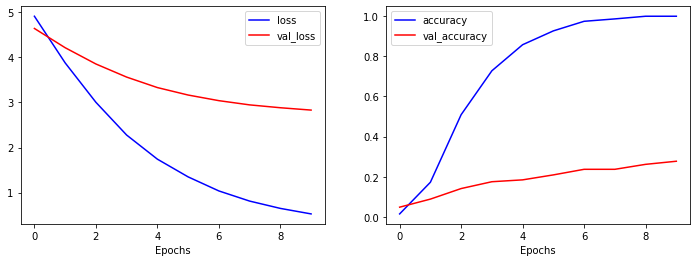

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(hist_2.history['loss'], 'b-', label = 'loss')
plt.plot(hist_2.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_2.history['accuracy'], 'b-',label = 'accuracy')
plt.plot(hist_2.history['val_accuracy'], 'r-', label = 'val_accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()


- 학습 결과가 매우 좋다. 
  - 특히 val_loss는 감소하는 추세를 보이고 val_accuracy는 증가하는 추세를 보이기 때문이다.
-validation data의 정확도는 그렇게 높지는 않지만 이는 epoch의 수가 부족하기 때문으로 보인다.
- 결과적으로 모델에 가중치의 변화를 준 것이 훨씬 학습에 용이함을 알 수 있다.

### 전이 학습을 이용해서 특징 추출기를 만들어 보자
- 특징 추출기를 전이 학습으로 만든다는 것은 미리 훈련된 모델에서 데이터의 특징만을 추출하고 작은 네트워크를 따로 만들어서 추출한 특징을 네트워크에 통과 시켜 정답을 예측하는 것을 의미한다.
- 이렇게 하게 되면 학습할 때 마다 전체 네트워크의 계산을 반복할 필요가 없어서 계산 시간은 훨씬 줄어들고 메모가 절약이 된다.
- 이번에는 tensorflow hub에 있는 model 중에 Inception V3를 이용해 볼 것이다.

In [46]:
import tensorflow_hub as hub

inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential(
    hub.KerasLayer(inception_url, output_shape = (2048,), trainable = False)
)
feature_model.build([None,299,299,3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


**전이 학습을 할 때에 제일 유의해야 하는 것은 이 모델이 어떤 크기의 입력값을 받고 어떠한 상태로 출력을 하는지 확인을 해 이에 맞추어서 데이터의 적재도 해 주어야 한다는 것이다.**
- 앞서 진행한 것과 마찬가지로 KerasLayer의 형식으로 모델안에 들어가는 하나의 layer로서 network를 불러온다. 
- 다운 받아준 network는 특징 추출기로 쓰이는 network라서 Dense layer을 포함하지 않아 output_shape가 (2048,)이다.  

- summary()함수를 이용해서 모델에 대해 알아보기 위해서는 우선적으로 compile()을 진행해 주어야 하는데 그냥 build() 함수를 이용해서 인수로 입력 데이터의 차원을 넣어 주는 방법도 존재한다.
  - input_shape의 첫번째 인수는 batch_size를 의미하는 것이기 때문에 알 수 없어서 None이나 -1로 설정해 주면 된다.(어떤 숫자도 가능하다는 의미)
- 학습을 위해서 이미지 데이터의 가로와 세로를 299로 바꾸어 주어야 하는데 메모리 부족으로 코랩이 다운될 수 있기 때문에 ImageDataGenerator을 이용해야 한다.
  - 이렇게 해서 디스크에서 배치 크기만큼 조금씩 읽어들이는 방법을 사용할 수 있다.
  - 그러나 ImageDataGenerator은 라벨이 있는 데이터를 처리할 때에 각 라벨의 이름을 하위 디렉터리로 가지고 있는 디렉터리를 받아서 그 데이터를 처리한다.
    - 따라서 데이터의 directory를 ImageDataGenerator이 받아 들일 수 있는 방법으로 복사하는 과정이 필수이다.

In [73]:
!kaggle datasets download -d miljan/stanford-dogs-dataset-traintest

 97% 381M/393M [00:06<00:00, 65.9MB/s]
100% 393M/393M [00:06<00:00, 63.9MB/s]


- kaggle에서 받은 zip파일의 압축을 풀고 '/root'라는 저장 경로에 저장해 준다.

In [ ]:
!unzip stanford-dogs-dataset-traintest.zip -d'/root'

- 내가 이용한 데이터는 그러나 라벨이 일일이 directory로 세분화 되어 설정이 되어 있었기 때문에 굳이 저장을 따로 복사해서 할 필요는 없었다.

In [85]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

image_size, batch_size = 299,64

train_datagen = ImageDataGenerator(rescale = 1./255., horizontal_flip=True, shear_range = 0.2, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.25)

train_datagenerator = train_datagen.flow_from_directory(directory = '/root/cropped/cropped/train', batch_size = batch_size, seed = 42, shuffle = True, class_mode = 'categorical', target_size = (image_size, image_size))
valid_datagenerator = valid_datagen.flow_from_directory(directory = '/root/cropped/cropped/test', batch_size = 1, seed = 42, shuffle = True, class_mode = 'categorical', target_size = (image_size, image_size))

Found 12000 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


- ImageDataGenerator을 이용하는 이유는 네트워크를 학습시킬 이미지 데이터는 이미지 보강을 해야 하기 때문이고, 검증 데이터는 별도의 이미지 보강 없이 원본을 그대로 사용하고자 한다.
- 이제 위에서 불러온 Inception V3모델을 이용해서 훈련 데이터와 검증 데이터의 특징 벡터를 추출할 필요가 있다.
  - 그리고 이렇게 변환한 특징 벡터를 이용해서 Sequential model을 만들어 실제 라벨을 예측하면 된다.

In [86]:
batch_step = (12000*3)//batch_size
train_features = []
train_y = []
for idx in range(batch_step):
  if idx % 100 == 0:
    print(idx)
  x,y = train_datagenerator.next()
  train_y.extend(y)

  feature = feature_model.predict(x)
  train_features.extend(feature)


0
100
200
300
400
500


In [96]:
valid_features = []
valid_y = []
for idx in range(100):
  if idx % 100 == 0:
    print(idx)
  x,y = valid_datagenerator.next()
  valid_y.extend(y)

  feature = feature_model.predict(x)
  valid_features.extend(feature)

0


In [97]:
train_features = np.array(train_features)
train_y = np.array(train_y)

valid_features = np.array(valid_features)
valid_y = np.array(valid_y)

- 첫줄은 batch_step을 지정해 준 것인데, training에 속하는 이미지의 크기인 20580에 3을 곱하고 batch_size인 128로 나누어서 데이터를 3번 정도 반복하여서 특징 벡터를 model에 넣어서 뽑아낸다.
- ImageDataGenerator에 next()함수를 사용하면 다음에 올 값을 반환 받을 수 있는데, 훈련 데이터에는 이미지의 분류에 해당하는 y값이 존재하기 때문에 이 y값은 train_y에 그대로 입력을 받을 수 있도록 한다.
- x값은 이미지 데이터에 해당하는 값으로, model에 넣어서 predict작업을 진행해 주면, 특 특징 추출기를 통과하면 특징 벡터를 train_features에 입력하면 된다.

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(learning_rate = 0.0001)

model = Sequential()
model.add(Dense(256, activation = 'relu', input_shape = (2048,)))
model.add(Dropout(0.3))
model.add(Dense(120, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               30840     
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


- loss로 categorical_crossentropy를 사용한 이유는 ImageDataGenerator을 이용하면 label이 one-hot-encoding되는데, 때문에 앞선 상황과 달리 shape의 마지막 인수가 class의 개수와 같았기 때문이다.
- sparse_categorical_crossentropy는 희소 행렬에서 사용한다.

- 기존에 내가 직접 만든 CNN모델로 학습을 진행한다면 처음부터 이미지를 넣겠지만 이렇게 **특징 추출기**를 **전이학습**으로 이용하는 경우에는 CNN의 convolution layer이 추출하는 **특징 벡터**를 입력값으로 받는 Deep Neural Network을 설계해서 사용하면 된다.

In [102]:
hist_4 = model.fit(train_features, train_y, validation_data = (valid_features, valid_y),epochs = 10, batch_size = batch_size)

Epoch 1/10
561/561 [==============================] - 6s 10ms/step - loss: 0.8588 - accuracy: 0.7774 - val_loss: 0.3088 - val_accuracy: 0.8900
Epoch 2/10
561/561 [==============================] - 5s 10ms/step - loss: 0.4301 - accuracy: 0.8659 - val_loss: 0.2885 - val_accuracy: 0.8900
Epoch 3/10
561/561 [==============================] - 5s 10ms/step - loss: 0.3615 - accuracy: 0.8843 - val_loss: 0.3217 - val_accuracy: 0.8600
Epoch 4/10
561/561 [==============================] - 5s 10ms/step - loss: 0.3139 - accuracy: 0.8982 - val_loss: 0.3214 - val_accuracy: 0.8900
Epoch 5/10
561/561 [==============================] - 5s 10ms/step - loss: 0.2810 - accuracy: 0.9074 - val_loss: 0.2854 - val_accuracy: 0.8900
Epoch 6/10
561/561 [==============================] - 6s 10ms/step - loss: 0.2509 - accuracy: 0.9158 - val_loss: 0.2978 - val_accuracy: 0.9200
Epoch 7/10
561/561 [==============================] - 5s 10ms/step - loss: 0.2325 - accuracy: 0.9218 - val_loss: 0.3529 - val_accuracy: 0.9000

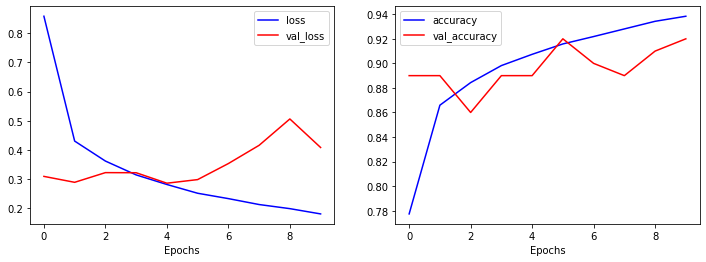

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(hist_4.history['loss'], 'b-', label = 'loss')
plt.plot(hist_4.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_4.history['accuracy'], 'b-', label = 'accuracy')
plt.plot(hist_4.history['val_accuracy'], 'r-', label='val_accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


- 보면 알 수 있겠지만 accuracy와 loss 모두 매우 이상적으로 각각 증가하고 감소한다.
- 물론 validation data로 충분하지 않은 양을 특징으로 출력하기는 했지만 그래도 특징 추출기가 제대로 훈련이 되어 있기에 얕은 DNN layer로도 학습이 가능하다.